In [13]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import sys
sys.path.append('../')

In [2]:
%load_ext autoreload
%autoreload 2

###### Noise Scheduler

In [3]:
class LinearNoiseScheduler():
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise
    
    def sample_prev_timestep(self, xt, t, noise_pred):
        x0 = (xt - self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)/(self.sqrt_alphas_cum_prod[t])
        x0 = torch.clamp(x0, -1, 1)

        mean = xt - ((1 - self.alphas[t])/self.sqrt_one_minus_alpha_cum_prod[t]) * noise_pred
        mean = mean/torch.sqrt(self.alphas[t])

        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alphas_cum_prod[t-1])/(1 - self.alphas_cum_prod[t])
            variance = variance*self.betas[t]
            sigma = torch.sqrt(variance)

            z = torch.randn_like(xt).to(xt.device)

            return mean + sigma*z, x0

Text(0.5, 1.0, 'Sqrt One Minus Alpha Cum Prod')

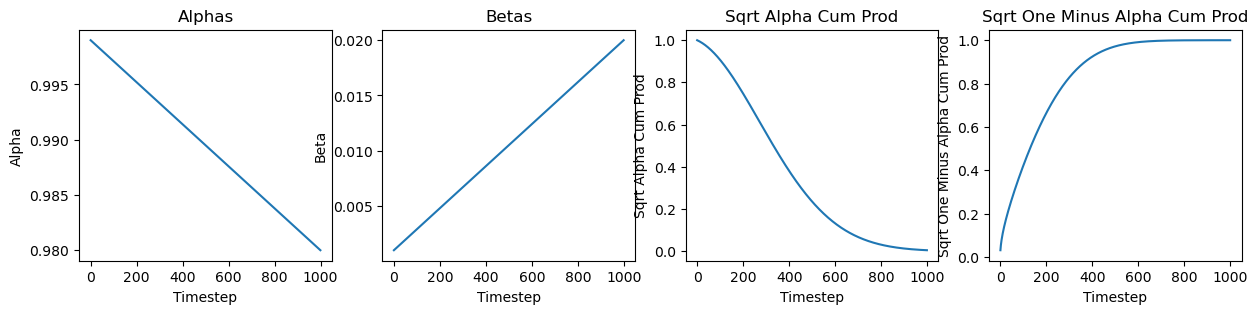

In [57]:
linear_scheduler = LinearNoiseScheduler(1000, 0.001, 0.02)

plt.figure(figsize=(15,3))
plt.subplot(1,4,1)
plt.plot(linear_scheduler.alphas)
plt.xlabel('Timestep')
plt.ylabel('Alpha')
plt.title('Alphas')

plt.subplot(1,4,2)
plt.plot(linear_scheduler.betas)
plt.xlabel('Timestep')
plt.ylabel('Beta')
plt.title('Betas')

plt.subplot(1,4,3)
plt.plot(linear_scheduler.sqrt_alphas_cum_prod)
plt.xlabel('Timestep')
plt.ylabel('Sqrt Alpha Cum Prod')
plt.title('Sqrt Alpha Cum Prod')

plt.subplot(1,4,4)
plt.plot(linear_scheduler.sqrt_one_minus_alpha_cum_prod)
plt.xlabel('Timestep')
plt.ylabel('Sqrt One Minus Alpha Cum Prod')
plt.title('Sqrt One Minus Alpha Cum Prod')


torch.Size([1, 3, 128, 128])


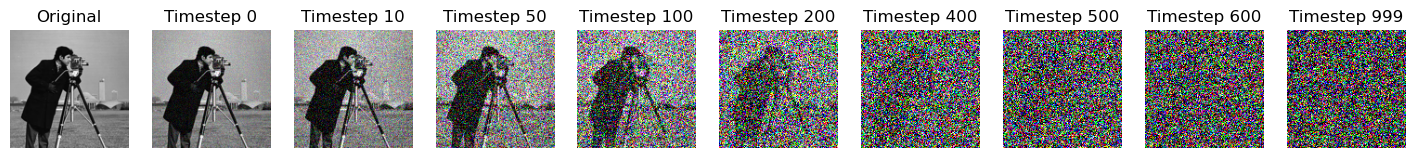

In [75]:
test_img = Image.open("../images/cameraman.jpg")
test_img = test_img.resize((128, 128))
test_img = transforms.ToTensor()(test_img).unsqueeze(0)
print(test_img.shape)
step = [0, 10, 50, 100, 200, 400, 500, 600,999]
plt.figure(figsize=(18,15))
plt.subplot(1,10,1)
plt.imshow(np.transpose(test_img[0].numpy(), (1,2,0)))
plt.title('Original')
plt.axis('off');
for i, j in enumerate(step):
    plt.subplot(1,10,i+2)
    noise = torch.randn_like(test_img)
    test_img_noisy = linear_scheduler.add_noise(test_img, noise, j)
    plt.imshow(np.transpose(torch.clamp(test_img_noisy[0], 0, 1).numpy(), (1,2,0)))
    plt.axis('off');
    plt.title(f'Timestep {j}')

###### Model

In [14]:
import yaml
from src.model import Unet
config_path = "../config/default.yaml"
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

In [19]:
model = Unet(config['model_params'])